# WGAN Gradient Penalty (WGAN-GP)
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Dr. Risman Adnan.*

-------
This notebook is adapted from the UI-SRIN Introduction to GANs github repository (https://github.com/DSC-UI-SRIN/Introduction-to-GAN/blob/master/2%20-%20Wasserstein%20GANs/WGAN.ipynb).

## Introduction
In this notebook I will implement the Wassertein GAN (WGAN) algorithm with gradient penalty (GP) to generate synthetic images that resemble images in the CIFAR10 dataset. 

Spectral normalization is weight normalization technique used to stabilize the training of a discriminator. 

## 1. Importing Libraries and Configuring the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.autograd as autograd
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT = "/content/drive/My Drive/Colab Notebooks/WGANs/WGAN-GP"
sample_dir = os.path.join(ROOT, 'sample')
# Make dir if no exist
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## 2. Dataset

### 2.1 Importing the dataset

In [3]:
batch_size = 100

# FashionMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./FashionMNNIST/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)


In [4]:
example_data.shape

torch.Size([100, 1, 28, 28])

In [5]:
LABELS = ['T-shirt/top',
'Trouser',
'Pullover',
'Dress',
'Coat',
'Sandal',
'Shirt',
'Sneaker',
'Bag',
'Ankle boot'
]

### 2.2 Previewing the dataset

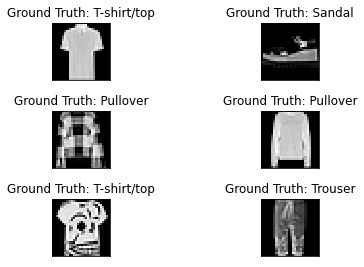

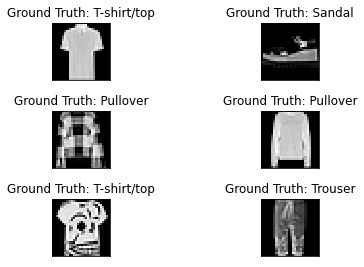

In [6]:
## Print example
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(LABELS[example_targets[i]]))
  plt.xticks([])
  plt.yticks([])
fig

## 3. Building the models

### 3.1 The Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(g_input_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, g_output_dim), 
            nn.Tanh())

    def forward(self, z):
        image = self.model(z)
        image = image.view(image.size(0), *example_data.shape[1:])
        return image

### 3.2 The Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(d_input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, image):
        img_flat = image.view(image.size(0), -1)
        validity = self.model(img_flat)
        return validity


## 4. Building the Network

In [9]:
# build network
z_dim = 100
cfar10_dim = train_dataset.data.shape[1] * train_dataset.data.shape[2] 
G = Generator(g_input_dim = z_dim, g_output_dim = cfar10_dim).to(device)
D = Discriminator(cfar10_dim).to(device)

In [10]:
print(G, D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)

## 5. Defining Gradient Penalty

In [11]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## 6. Training the Model

In [12]:
# Loss weight for gradient penalty
lambda_gp = 10

# optimizer
lr = 0.0002
n_critic =  5
b1 = 0.5
b2 = 0.999

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))

In [13]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
epochs = 200
list_loss_D = []
list_loss_G = []
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], z_dim))))

        # Generate a batch of images
        fake_imgs = G(z).detach()

        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(D, real_imgs.data, fake_imgs.data)

        # Adversarial loss
        d_loss = -torch.mean(D(real_imgs)) + torch.mean(D(fake_imgs)) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = G(z)
            # Adversarial loss
            g_loss = -torch.mean(D(gen_imgs))

            g_loss.backward()
            optimizer_G.step()

            list_loss_D.append(d_loss.item())
            list_loss_G.append(g_loss.item())
        if i % 300 == 0:
            print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, epochs, i, len(train_loader), d_loss.item(), g_loss.item()))

    if epoch % 5 == 0:
        save_image(gen_imgs.view(gen_imgs.size(0), 1, 28, 28), os.path.join(sample_dir, "%d.png" % epoch), nrow=5, normalize=True)

torch.save(G, os.path.join(ROOT, 'G.pt'))
torch.save(D, os.path.join(ROOT, 'D.pt'))

[Epoch 0/200] [Batch 0/600] [D loss: 9.463260] [G loss: -0.485976]
[Epoch 0/200] [Batch 300/600] [D loss: 3.410667] [G loss: -0.334292]
[Epoch 1/200] [Batch 0/600] [D loss: 4.352021] [G loss: -0.311956]
[Epoch 1/200] [Batch 300/600] [D loss: 5.478914] [G loss: -0.207759]
[Epoch 2/200] [Batch 0/600] [D loss: 4.595310] [G loss: -0.142933]
[Epoch 2/200] [Batch 300/600] [D loss: 7.925518] [G loss: -0.983207]
[Epoch 3/200] [Batch 0/600] [D loss: 1.149880] [G loss: -0.939823]
[Epoch 3/200] [Batch 300/600] [D loss: 1.789029] [G loss: -0.426302]
[Epoch 4/200] [Batch 0/600] [D loss: 5.063324] [G loss: -0.998950]
[Epoch 4/200] [Batch 300/600] [D loss: 6.662524] [G loss: -0.746853]
[Epoch 5/200] [Batch 0/600] [D loss: 1.811653] [G loss: -0.990042]
[Epoch 5/200] [Batch 300/600] [D loss: 4.589396] [G loss: -0.988366]
[Epoch 6/200] [Batch 0/600] [D loss: 6.305082] [G loss: -0.000000]
[Epoch 6/200] [Batch 300/600] [D loss: 1.686157] [G loss: -0.318294]
[Epoch 7/200] [Batch 0/600] [D loss: 2.748981] [

## 7. Viewing the results

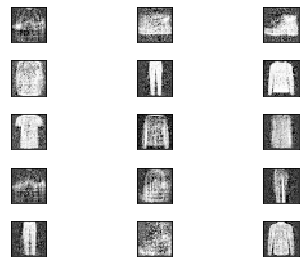

In [14]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
z = Variable(Tensor(np.random.normal(0, 1, (15, z_dim))))
gen_imgs = G(z).detach()
fig = plt.figure()
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.tight_layout()
    plt.imshow(gen_imgs[i].cpu().view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])